# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [4]:
# This cell is finished

from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [3]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter)
filterResponseSobelX = signal.convolve2d(image, sobelX)
filterResponseSobelY = signal.convolve2d(image, sobelY)

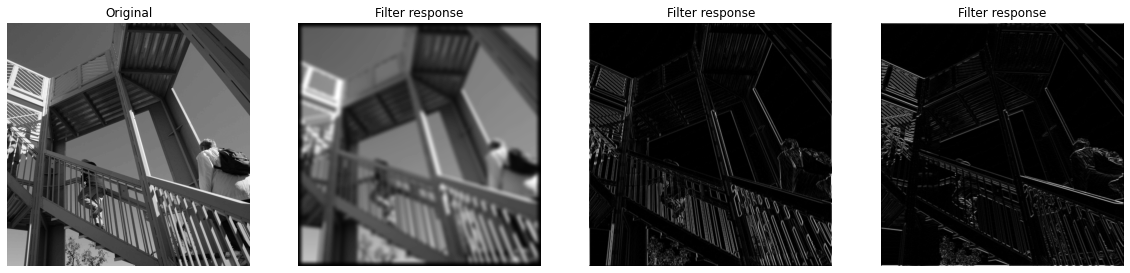

In [4]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

(3, 3)

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

- gausian blur, SobelX - vertical lines, sobelY - horizontal lines 

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

- original - 512 x 512, 1 channels, normal image has 3: R,G,B 

Question 3: What is the size of the different filters?

- gausian filter : 15 x 15
- sobelX : 3x3 
- sobelY: 3x3

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

- same as original image

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

- will be smaller by filtersize - 1

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers? 

- because after many convoliutios image will run out of pixels. 


In [8]:
print(image.shape)
print(gaussFilter.shape)
print(sobelX.shape)
print(sobelY.shape)
print(signal.convolve2d(image, gaussFilter,"same").shape)
print(signal.convolve2d(image, gaussFilter,"valid").shape)

(512, 512)
(15, 15)
(3, 3)
(3, 3)
(512, 512)
(498, 498)


##  Part 3: Get a graphics card

Skip this part if you run on a CPU

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [4]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ?
- because image has 3 chanels 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested? 
- no, Conv2D does not rotate filter by 180 degrees. 

Lets investigate how much faster a convolution is with the graphics card (skip this part if you run on a CPU)

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?
- x7 

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

- x1.37, because in 2 images not much parrelization can be done

In [21]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(cpu_time/gpu_time))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.0834735999997065
GPU (s):
0.060723000000507454
GPU speedup over CPU: 1.37466198967457x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [6]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

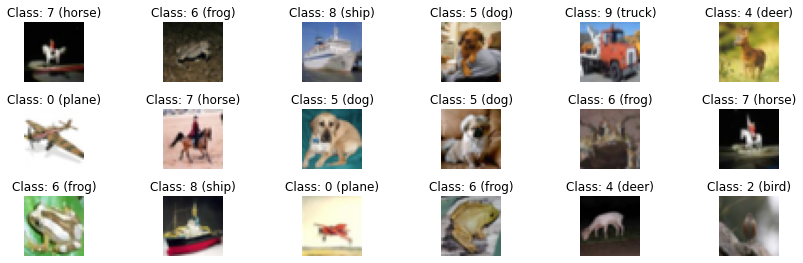

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [8]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size = 0.25)

# Print the size of training data, validation data and test data
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(7500, 32, 32, 3)
(2500, 32, 32, 3)
(2000, 32, 32, 3)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [9]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [10]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print("before")
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain)
Yval = to_categorical(Yval)
Ytest = to_categorical(Ytest)

# Print shapes after converting the labels
print("after")
print(Ytrain.shape)
print(Yval.shape)
print(Ytest.shape)

before
(7500, 1)
(2500, 1)
(2000, 1)
after
(7500, 10)
(2500, 10)
(2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01, drop_rate = 0.5):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters = n_filters, kernel_size = 3, padding = "same", activation = "relu", input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(1,n_conv_layers):
        model.add(Conv2D(filters =2 * i * n_filters, kernel_size = 3, padding = "same", activation = "relu", input_shape = input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes, activation='relu'))
        if use_dropout:
            model.add(Dropout(drop_rate))
    # Add final dense layer
    model.add(Dense(10, activation='softmax'))
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate = learning_rate),
        loss = "categorical_crossentropy",
        metrics=['accuracy'])
    
    return model

In [12]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [46]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain[0, :].shape

# Build model
model1 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, learning_rate=0.01)
# Train the model  using training data and validation data

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history1 = model1.fit(
    x=Xtrain,
    y=Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(Xval,Yval),
    callbacks = [callback]
    )

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [47]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(
    x = Xtest,
    y = Ytest
)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 4ms/step - loss: 2.3317 - accuracy: 0.5470
Test loss: 2.3317
Test accuracy: 0.5470


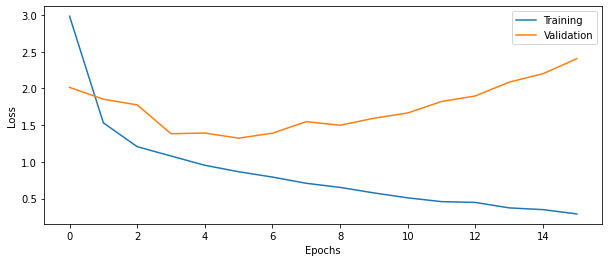

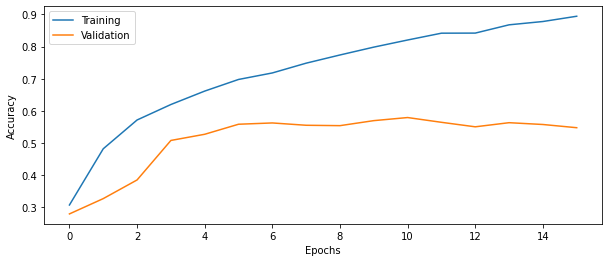

In [48]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Skip question 12 if you run on a CPU

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 0.5285, could be much better 

Question 11: How big is the difference between training and test accuracy? 

- 0.3528 

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

- 60% 3533mb 

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration? 

- image has more data 512x512, more parameters to estimate...

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [50]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain[0, :].shape

# Build model
model2 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, learning_rate=0.01, n_dense_layers=1, n_nodes=50)
# Train the model  using training data and validation data

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history2 = model2.fit(
    x=Xtrain,
    y=Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(Xval,Yval),
    callbacks = [callback]
    )

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [52]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(
    x = Xtest,
    y = Ytest
)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 4ms/step - loss: 2.4438 - accuracy: 0.5285
Test loss: 2.4438
Test accuracy: 0.5285


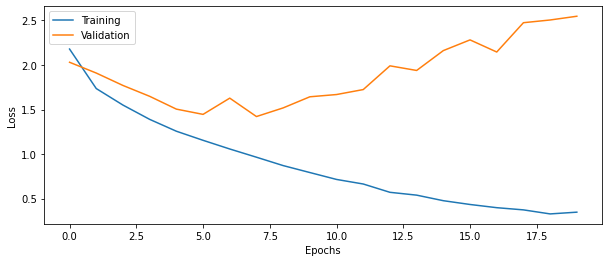

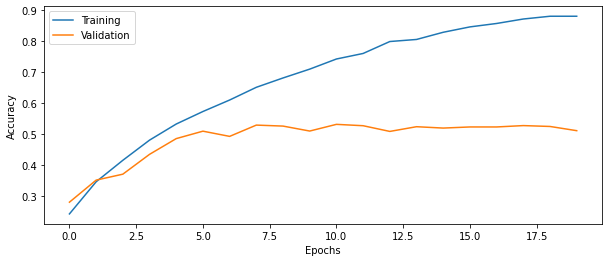

In [53]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [55]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain[0, :].shape

# Build model
model3 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, learning_rate=0.01, n_dense_layers=1, n_nodes=50)
# Train the model  using training data and validation data

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history3 = model3.fit(
    x=Xtrain,
    y=Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(Xval,Yval),
    callbacks = [callback]
    )

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [56]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(
    x = Xtest,
    y = Ytest
)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 5ms/step - loss: 2.7686 - accuracy: 0.5455
Test loss: 2.7686
Test accuracy: 0.5455


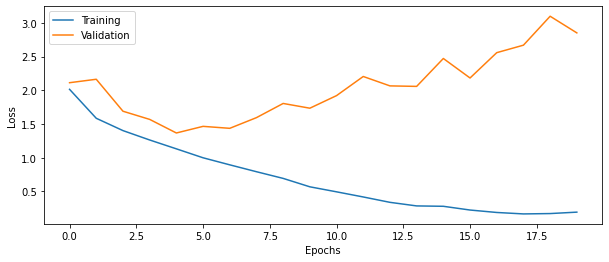

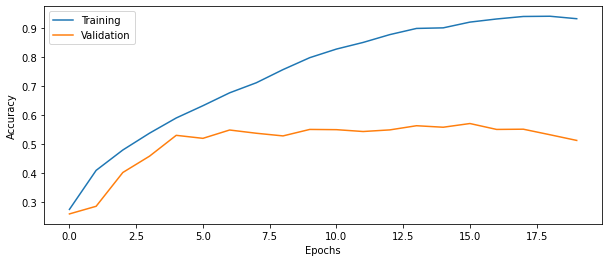

In [57]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

- trainable parameters: 99,152
- conv2D with 96 filters - 55392 

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output?

- input: K NxN images where K is a number of filters
- output: G NxN images where G is a number of filters defined in conv layer

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

- Yes

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

- 128

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

 - number_parameters = out_channels * (in_channels * kernel_h * kernel_w + 1) https://stackoverflow.com/questions/58991594/understanding-number-of-parameters-in-keras-conv2d-layer

Question 19: How does MaxPooling help in reducing the number of parameters to train?

- it reduces dimensions of images by taking maximum value from the pool. 

In [58]:
# Print network architecture

model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_268 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_269 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_27 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 8, 8, 64)        

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout? 

- 0.0055

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

- l1,l2,l1_l2 (elastic net )
- with  kernel_regularizer='l2' parameter 

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [61]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain[0, :].shape

# Build model
model4 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, learning_rate=0.01, n_dense_layers=1, n_nodes=50, use_dropout = True)
# Train the model  using training data and validation data

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history4 = model4.fit(
    x=Xtrain,
    y=Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(Xval,Yval),
    callbacks = [callback]
    )

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [65]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(
    x = Xtest,
    y = Ytest
)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 5ms/step - loss: 1.6219 - accuracy: 0.5510
Test loss: 1.6219
Test accuracy: 0.5510


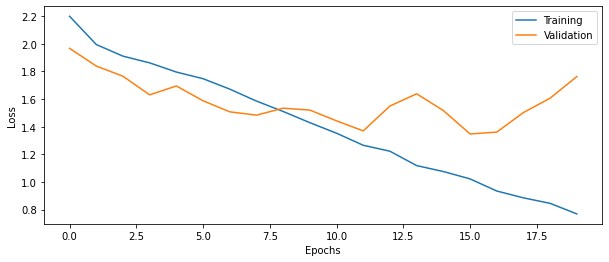

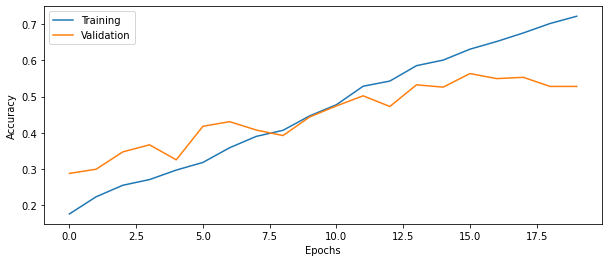

In [66]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration? 

- 0.5745

- nodes 40, dense_layers 4, n_conv_layers 3, n_filters 11, learning_rate 0.01, drop_rate 0.1.


## Your best config

In [79]:
def nn_tuner(hp):
    hp_units_neurons = hp.Int('neuron_units', min_value=10, max_value=100, step=10)
    hp_units_layers = hp.Int('n_dense_layers', min_value=0, max_value=16, step=2)
    hp_n_conv_layers = hp.Int('n_conv_layers', min_value=1, max_value=5, step=1)
    hp_n_filters = hp.Int('n_filters', min_value=3, max_value=13, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1 ,1e-2, 1e-3, 1e-4])
    hp_drop_rate = hp.Choice('drop_rate', values=[0.1 ,0.2, 0.3, 0.4,0.5])
    
    return build_CNN(input_shape, n_conv_layers=hp_n_conv_layers, n_filters=hp_n_filters, n_dense_layers=hp_units_layers, n_nodes=hp_units_neurons, use_dropout=True, learning_rate= hp_learning_rate, drop_rate = hp_drop_rate)
    

In [81]:
import kerastuner as kt

tuner = kt.Hyperband(nn_tuner,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='my_dir',
                     project_name='5')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(Xtrain, Ytrain, epochs=50, batch_size = 300, validation_data=(Xval, Yval), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
hp_units_neurons  {best_hps.get('neuron_units')}, hp_units_layers {best_hps.get('n_dense_layers')},
hp_n_conv_layers {best_hps.get('n_conv_layers')}, hp_n_filters {best_hps.get('n_filters')}, hp_learning_rate {best_hps.get('learning_rate')},
hp_drop_rate {best_hps.get('drop_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project my_dir\5\oracle.json


INFO:tensorflow:Reloading Oracle from existing project my_dir\5\oracle.json


INFO:tensorflow:Reloading Tuner from my_dir\5\tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir\5\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



hp_units_neurons  40, hp_units_layers 4,
hp_n_conv_layers 3, hp_n_filters 11, hp_learning_rate 0.01,
hp_drop_rate 0.1.



In [83]:
# Setup some training parameters
# Setup some training parameters
batch_size = 300
epochs = 200
input_shape = Xtrain[0, :].shape


# Build model
model5 = build_CNN(input_shape, n_conv_layers=3, n_filters=11, n_dense_layers=4, n_nodes=40, use_dropout=True, learning_rate= 0.01, drop_rate = 0.1)

# Train the model  using training data and validation data
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

history5 = model5.fit(
    x=Xtrain,
    y=Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(Xval,Yval),
    callbacks = [callback]
    )

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


25/25 - 1s - loss: 2.1055 - accuracy: 0.2025 - val_loss: 2.3298 - val_accuracy: 0.0976
Epoch 2/200
25/25 - 0s - loss: 1.7626 - accuracy: 0.3391 - val_loss: 2.1951 - val_accuracy: 0.1836
Epoch 3/200
25/25 - 0s - loss: 1.6226 - accuracy: 0.3940 - val_loss: 2.0021 - val_accuracy: 0.3116
Epoch 4/200
25/25 - 0s - loss: 1.5182 - accuracy: 0.4403 - val_loss: 1.6870 - val_accuracy: 0.3908
Epoch 5/200
25/25 - 0s - loss: 1.4147 - accuracy: 0.4821 - val_loss: 1.8101 - val_accuracy: 0.3984
Epoch 6/200
25/25 - 0s - loss: 1.3331 - accuracy: 0.5161 - val_loss: 1.7646 - val_accuracy: 0.4056
Epoch 7/200
25/25 - 0s - loss: 1.2736 - accuracy: 0.5384 - val_loss: 1.5202 - val_accuracy: 0.4656
Epoch 8/200
25/25 - 0s - loss: 1.1985 - accuracy: 0.5751 - val_loss: 1.4792 - val_accuracy: 0.4800
Epoch 9/200
25/25 - 0s - loss: 1.1320 - accuracy: 0.5889 - val_loss: 1.3521 - val_accuracy: 0.5228
Epoch 10/200
25/25 - 0s - loss: 1.0961 - accuracy: 0.6101 - val_loss: 1.3492 - val_accuracy: 0.5308
Epoch 11/200
25/25 - 

In [84]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(
    x = Xtest,
    y = Ytest
)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 5ms/step - loss: 2.3723 - accuracy: 0.5745
Test loss: 2.3723
Test accuracy: 0.5745


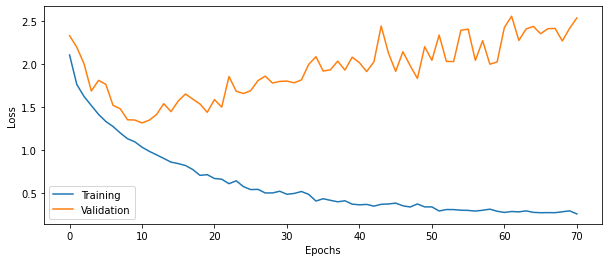

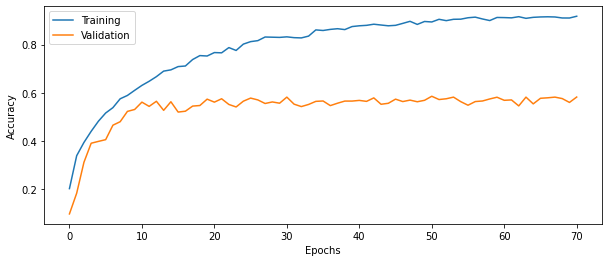

In [85]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy. 

- 0.2225 , loss of accuracy can be explained due to the lack of learning towards rotated patterns which are present in the test but not in the training stage 

In [20]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

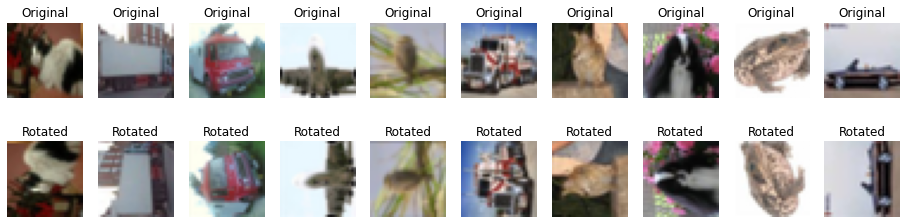

In [21]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [89]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(
    x = Xtest_rotated,
    y = Ytest
)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 0s 4ms/step - loss: 5.6360 - accuracy: 0.2225
Test loss: 5.6360
Test accuracy: 0.2225


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/ , the `flow` method should be used

Do *NOT* use use_multiprocessing=True here, as it can cause strange errors.

In [13]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [16]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=30,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.2)


image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(Xtrain)

# Setup a flow for training data, assume that we can fit all images into CPU memor
batch_size = 300

train_generator = image_datagen.flow(
    x = Xtrain,
    y = Ytrain,
    batch_size=batch_size,
    subset='training')

# Setup a flow for validation data, assume that we can fit all images into CPU memory

val_generator = image_datagen.flow(
    x = Xtrain,
    y = Ytrain,
    batch_size=batch_size,
    subset='validation')

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change? 

- use flow_from_directory

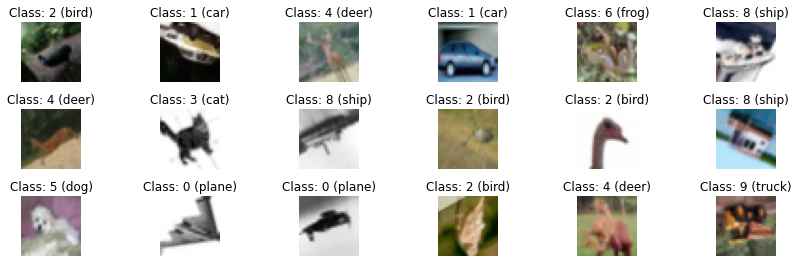

In [17]:
# Plot some augmented images
plot_datagen = image_datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

- accuracy with augmented data increasing slower , because images are less similar between themselves 
- number of epochs 

Question 26: What other types of image augmentation can be applied, compared to what we use here?

    featurewise_center=False - Set input mean to 0 over the dataset, feature-wise 

    samplewise_center=False -  Set each sample mean to 0
    
    featurewise_std_normalization=False, - Divide inputs by std of the dataset, feature-wise.
    
    samplewise_std_normalization=False, - Divide each input by its std.
    
    zca_whitening=False, - Apply ZCA 
    
    zca_epsilon=1e-06, - epsilon for ZCA whitening
    
    rotation_range=0, - Degree range for random rotations
    
    width_shift_range=0.0, 
    
    height_shift_range=0.0,
    
    brightness_range=None,
    
    shear_range=0.0, - Shear angle in counter-clockwise direction in degrees
    
    zoom_range=0.0,
    
    channel_shift_range=0.0, 
    

In [18]:
# Setup some training parameters
batch_size = 300
epochs = 200
input_shape = Xtrain[0].shape

# Build model (your best config)
model6 = build_CNN(input_shape, n_conv_layers=3, n_filters=11, n_dense_layers=4, n_nodes=40, use_dropout=True, learning_rate= 0.01, drop_rate = 0.1)

validation_split=0.2
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)    
# Train the model using on the fly augmentation
history6 = model6.fit(
                    train_generator,
                    steps_per_epoch= len(Xtrain)*(1 - validation_split)/batch_size,
                    validation_data = val_generator,
                    validation_steps = len(Xtrain)*validation_split/batch_size,
                    epochs=epochs, callbacks = [callback])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/26 [==============================] - ETA: 0s - loss: 2.1407 - accuracy: 0.1943WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000271A4476798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

In [22]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.3710
Test accuracy: 0.5405
Test loss: 2.2923
Test accuracy: 0.2670


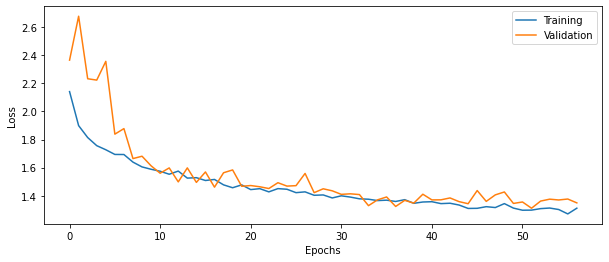

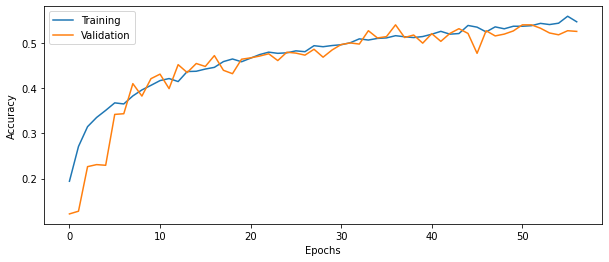

In [23]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [24]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


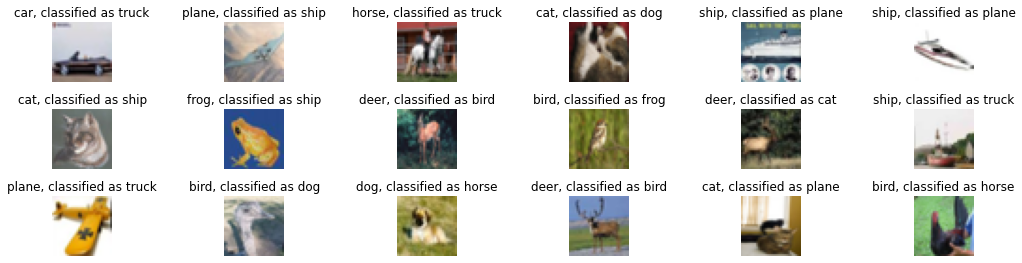

In [25]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case? 

- no, because during the transition from convolutional blocks to dense (flatten) layer will have more nodes thann before and weight matrix wont match. 

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

- yes it has to be fully convolutional.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

- 52

Question 30: How many trainable parameters does the ResNet50 network have?

- 25,583,592

Question 31: What is the size of the images that ResNet50 expects as input? 

- 224x224x3

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

- because its computationally expensive to calculate second derivative for that amount of parameters

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class? 2/5 correct: 

- beer bottle: beer_bottle 99%
- house: library 28%
- beer can: paper_towel 30%
- karen: Wig 9.7 % 
- lion: lion 97 % 

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [116]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array


model7 = ResNet50(weights='imagenet')
#model7.summary()

heineken = load_img( "heineken.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')


In [124]:
heineken = preprocess_input(img_to_array(load_img( "heineken.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')))
house = preprocess_input(img_to_array(load_img( "house.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')))
can = preprocess_input(img_to_array(load_img( "kalnapilis.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')))
karen = preprocess_input(img_to_array(load_img( "karen.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')))
lion = preprocess_input(img_to_array(load_img( "lion.jpg", color_mode='rgb', target_size=(256,256,3), interpolation='nearest')))

In [126]:
data = np.array([heineken, house, can, karen, lion])

In [134]:
print('Predicted:', decode_predictions(model7.predict(data), top=1))

Predicted: [[('n02823428', 'beer_bottle', 0.9908077)], [('n03661043', 'library', 0.28131568)], [('n03887697', 'paper_towel', 0.30069485)], [('n04584207', 'wig', 0.097884685)], [('n02129165', 'lion', 0.992428)]]
